In [46]:
import pandas as pd
import numpy as np
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Load Data
traffic_df = pd.read_csv('agg_data/conv_traf.csv')
traffic_df.head()

,fullVisitorId,date,conversion,convSoFar,value,source,medium,channelGrouping,isTrueDirect,newVisitor,isNewVisit,isFirstConversion
0,1235242196175467,2016-11-01,0,0,NaN,baidu,organic,Organic Search,NaN,1.0,1.0,0
1,15980521034237800,2016-12-08,0,0,NaN,facebook.com,referral,Social,NaN,1.0,1.0,0
2,34572692224994048,2016-10-03,0,0,NaN,baidu,organic,Organic Search,NaN,1.0,1.0,0
3,40335064426021006,2016-08-31,0,0,NaN,phandroid.com,referral,Referral,NaN,1.0,1.0,0
4,47788902811115718,2016-12-14,0,0,NaN,adwords.google.com,referral,Referral,NaN,1.0,1.0,0


**Note: the dataset only included the records where the user first converted and hasn't converted within 2016-08 till 2017-08.**

In [47]:
traffic_df['conversion'].unique()

array([0, 1], dtype=int64)

In [48]:
# Fill na by False for isTrueDirect
traffic_df['isTrueDirect'] = traffic_df['isTrueDirect'].fillna(False)
traffic_df['isTrueDirect'].unique()

array([False,  True])

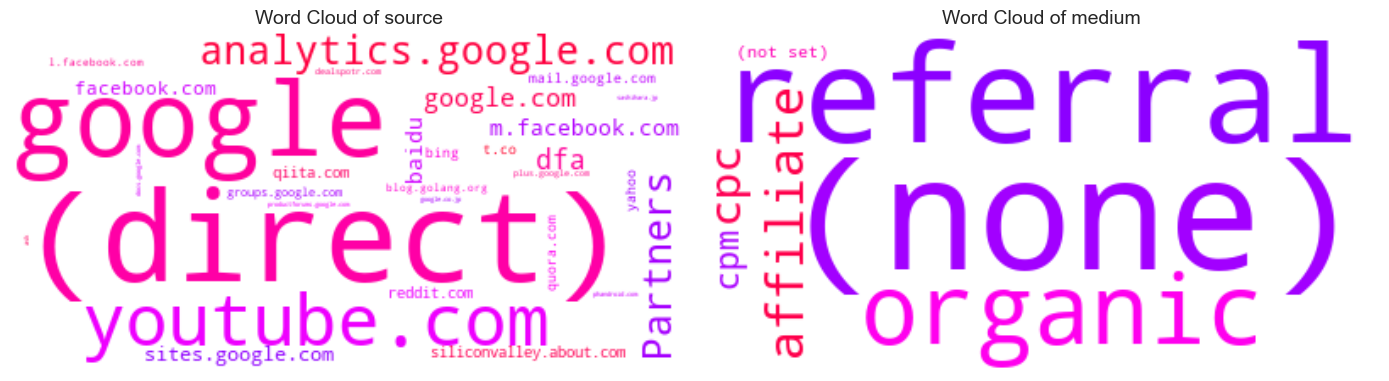

In [49]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import random

# Rainbow Coloring Function
def rainbow_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    hue = random.randint(270, 350)  # Random hue for rainbow effect
    return f"hsl({hue}, 100%, 50%)"  # Full saturation and medium brightness for vibrant colors

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

for i, col in enumerate(['source', 'medium']):
    # Count unique words
    word_counts = Counter(traffic_df[col].tolist())

    # Generate WordCloud using frequency dictionary
    wordcloud = WordCloud(max_words=30, background_color="white").generate_from_frequencies(word_counts)

    # Plot in subplot
    axes[i].imshow(wordcloud.recolor(color_func=rainbow_color_func, random_state=3), interpolation='bilinear')
    axes[i].set_title(f'Word Cloud of {col}', fontsize=14)
    axes[i].axis("off")  # Hide axes

# Adjust layout
plt.tight_layout()
plt.show()

The word cloud for medium has referral as the main medium, but looking at the sources, Partners and dfa contribute much less than direct and google. This indicates that some customers might have click off the site and re-entered them directly after some time.

In [50]:
traffic_df['medium'].value_counts()

medium
(none)       371467
referral     262022
organic      234381
affiliate     16403
cpc           13079
cpm            6184
(not set)       117
Name: count, dtype: int64

The medium displayed above are explained in the following based on Google Analytics:

- cpc (Cost Per Click):	Paid search traffic where you pay per click (Google Ads, Bing Ads).
- organic:	Free search engine traffic (Google, Bing, etc.).
- referral:	Traffic from another website linking to yours.
- affiliate: Traffic from an affiliate marketing partner.
- cpm (Cost Per Mille): Paid traffic from display ads where you pay per 1,000 impressions, not per click (Youtube, Facebook, etc.).
- (none): No medium was used (direct or lost assesses to the site).
- (not set): unknown.

Referenced from [here](https://measureschool.com/source-medium-google-analytics/).

In [51]:
# Check whether all '(none)' medium has the source '(direct)', vice versa
print(traffic_df.loc[traffic_df['medium'] == '(none)', 'source'].value_counts())
print(traffic_df.loc[traffic_df['source'] == '(direct)', 'medium'].value_counts())

# Check distribution of isTrueDirect across sources
pd.crosstab(index=traffic_df['isTrueDirect'], columns=traffic_df['medium'])

source
(direct)    371467
Name: count, dtype: int64
medium
(none)    371467
cpm            2
Name: count, dtype: int64


medium,(none),(not set),affiliate,cpc,cpm,organic,referral
isTrueDirect,,,,,,,
False,167167,100,13466,10386,4580,192785,241164
True,204300,17,2937,2693,1604,41596,20858


All direct source refers to the '(none)' medium except for two from 'cpm' medium, which violates the definition of mediums and source and they will be removed. Furthermore, it seems 'isTrueDirect' is Google Analytics' indicator to whether the user assessed the website directly during their visit.

In [52]:
# Drop direct cpm instances
traffic_df = traffic_df.loc[~((traffic_df['source'] == '(direct)') & (traffic_df['medium'] == 'cpm'))]

In [53]:
# Check whether all direct source has isTrueDirect as True, if not, then 'isTrueDirect' is just a guess variable.
traffic_df.loc[traffic_df['source'] == '(direct)', 'isTrueDirect'].unique()

array([False,  True])

In [54]:
# Redefine the medium column based on their definitions
map_dictionary = {'organic': 'Search', '(none)': 'Direct', 
                  'referral': 'Referral', 'cpc':'Paid Search', 
                  'affiliate': 'Affiliate', 'cpm': 'Display Ad', '(not set)': 'Direct'}

traffic_df['medium'] = traffic_df['medium'].map(map_dictionary)

traffic_df['medium'].value_counts()

medium
Direct         371584
Referral       262022
Search         234381
Affiliate       16403
Paid Search     13079
Display Ad       6182
Name: count, dtype: int64

## Conversion Rate by Medium

Look at the pathway the users took, or the pathway customers took before their conversion.

In [55]:
# check fullVisitorId count
count = traffic_df['fullVisitorId'].value_counts(ascending = False)

print("Between 2016-08-01 to 2017-07-31, there are %s distinct visitor IDs, and %s total records." % (len(count),len(traffic_df), ))

Between 2016-08-01 to 2017-07-31, there are 723246 distinct visitor IDs, and 903651 total records.


In [56]:
# Conversion rates
conversion_rate = traffic_df['conversion'].sum() / len(traffic_df)
conversion_rate

0.012783696360652509

In [57]:
# Filter dataset 
filter_df = traffic_df[['fullVisitorId', 'date','conversion', 'value', 'medium', 'isNewVisit', 'isFirstConversion']]

# Fill NaN by 0
filter_df = filter_df.fillna(0)

# Count the number of visits without conversion
filter_df['null'] = np.where(filter_df['conversion'] == 0,1,0)

# Sort by date
filter_df = filter_df.sort_values('date', ascending = True)
filter_df

,fullVisitorId,date,conversion,value,medium,isNewVisit,isFirstConversion,null
352385,3259411844793303374,2016-08-01,0,0.0,Direct,1.0,0,1
602225,8782513642833614098,2016-08-01,0,0.0,Search,1.0,0,1
272021,8247388453936975366,2016-08-01,0,0.0,Direct,1.0,0,1
295426,429222405901537951,2016-08-01,0,0.0,Direct,1.0,0,1
180746,1938701249830982521,2016-08-01,0,0.0,Direct,1.0,0,1
...,...,...,...,...,...,...,...,...
194688,9056142977539232796,2017-08-01,0,0.0,Direct,1.0,0,1
250961,1181536979112804688,2017-08-01,0,0.0,Direct,1.0,0,1
376262,7088705342426305552,2017-08-01,0,0.0,Direct,1.0,0,1
75716,9275765194937241914,2017-08-01,0,0.0,Direct,1.0,0,1


isFirstConversion
0    0.984812
1    0.015188
Name: proportion, dtype: float64


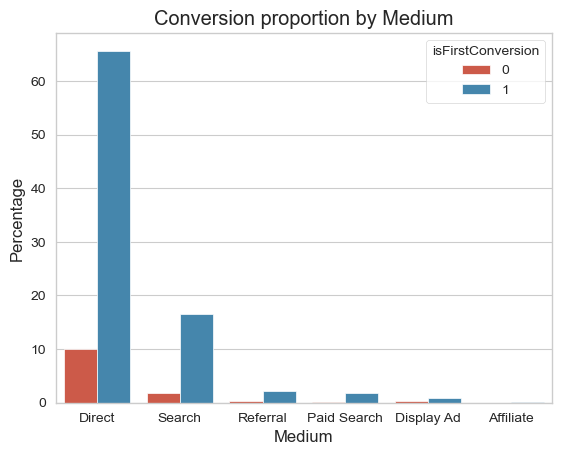

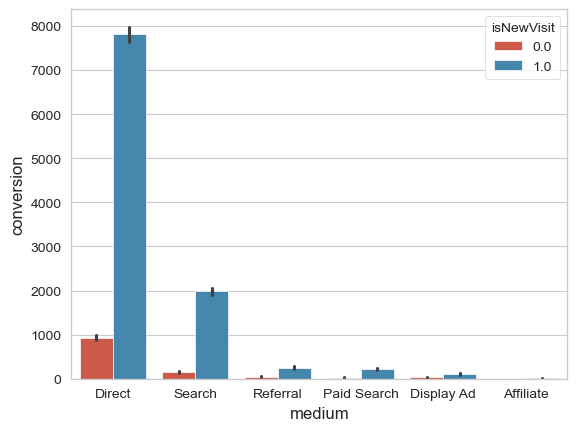

In [58]:
import seaborn as sns

# Percentage of first conversions from all conversions
print(filter_df['isFirstConversion'].value_counts(normalize = True))

# Aggegrate fitered data sorted by date
grouped = filter_df.groupby(['medium','isFirstConversion']).agg(
    total_conversions = ('conversion', 'sum'),
    total_nulls = ('null', 'sum')
)
grouped['conversion_rate_all'] = grouped['total_conversions'] * 100/(len(filter_df) * conversion_rate)

# Plot conversion rate by medium in ascending order
sns.barplot(data = grouped.sort_values(by='conversion_rate_all', ascending=False), x = 'medium', y = 'conversion_rate_all', hue = 'isFirstConversion')
plt.title('Conversion proportion by Medium')
plt.ylabel('Percentage')
plt.xlabel('Medium')
plt.show()

# Countplot for medium by new visitors and returning customers
sns.barplot(data = filter_df, x = 'medium', y= 'conversion', estimator= 'sum', hue = 'isNewVisit')
plt.show()

Direct has the highest conversion rate from all conversions (0.74%). The displayed advertisements and paid search has similar conversion rate to direct but the conversion rate is less than 0.1% from all visits. Search has a lower conversion rate than the forementioned mediums, but the second highest in conversion rate from all visits. Referral and affiliate have the least conversion rate. Similar percentage of first conversions from new visitors and conversions from returning customers.

## Multitouch Attirbution

Now, the relationship between medium should be looked into, Markov models in channel attribution package [ChannelAttribution](https://github.com/DavideAltomare/ChannelAttribution).

In [59]:
# Compile the journey of each visitor
path_df = filter_df.groupby('fullVisitorId').agg(
    path = ('medium', lambda x: x.tolist())
).reset_index()

In [60]:
# Check path variable
path_df['path_count'] = path_df['path'].apply(len)
path_df = path_df.sort_values('path_count', ascending = False)
path_df.head()

,fullVisitorId,path,path_count
221300,3608475193341679870,"[Paid Search, Paid Search, Paid Search, Paid S...",201
145223,1957458976293878100,"[Search, Search, Search, Search, Search, Searc...",167
205690,3269834865385146569,"[Direct, Direct, Direct, Direct, Direct, Direc...",155
74622,720311197761340948,"[Referral, Referral, Referral, Referral, Refer...",153
674025,7634897085866546110,"[Direct, Direct, Direct, Direct, Direct, Direc...",139


In [61]:
#Looking at the last interaction to see if it led to a user converting
last_interaction_df = filter_df.drop_duplicates('fullVisitorId', keep='last')[['fullVisitorId', 'conversion', 'value']]
last_interaction_df.head()

,fullVisitorId,conversion,value
352385,3259411844793303374,0,0.0
602225,8782513642833614098,0,0.0
295426,429222405901537951,0,0.0
180746,1938701249830982521,0,0.0
684774,3608695950774348121,0,0.0


In [62]:
#Concatinating with the dataframes of user path's
path_df = pd.merge(path_df, last_interaction_df, how='left', on='fullVisitorId')
path_df.head()

,fullVisitorId,path,path_count,conversion,value
0,3608475193341679870,"[Paid Search, Paid Search, Paid Search, Paid S...",201,0,0.0
1,1957458976293878100,"[Search, Search, Search, Search, Search, Searc...",167,0,0.0
2,3269834865385146569,"[Direct, Direct, Direct, Direct, Direct, Direc...",155,0,0.0
3,720311197761340948,"[Referral, Referral, Referral, Referral, Refer...",153,0,0.0
4,7634897085866546110,"[Direct, Direct, Direct, Direct, Direct, Direc...",139,0,0.0


In [63]:
#We will create a variable ‘path’ in the specific formatrequired by the Attribution Model where the ordered channels a user interacts with are delimited by'>'
path_df['path'] = path_df['path'].apply(lambda x : ' > '.join(x) if len(x) > 1 else x[0])
path_df

,fullVisitorId,path,path_count,conversion,value
0,3608475193341679870,Paid Search > Paid Search > Paid Search > Paid...,201,0,0.0
1,1957458976293878100,Search > Search > Search > Search > Search > S...,167,0,0.0
2,3269834865385146569,Direct > Direct > Direct > Direct > Direct > D...,155,0,0.0
3,720311197761340948,Referral > Referral > Referral > Referral > Re...,153,0,0.0
4,7634897085866546110,Direct > Direct > Direct > Direct > Direct > D...,139,0,0.0
...,...,...,...,...,...
723241,4387852089660520402,Direct,1,0,0.0
723242,4387884616302795716,Search,1,0,0.0
723243,4387906330010663443,Search,1,0,0.0
723244,4387929092489391260,Direct,1,0,0.0


In [64]:
#Removing the vistor's ID and grouping by the path to see the how many times a specific combination of channels led to a conversion or null outcome
path_df.drop(['fullVisitorId', 'path_count'], axis = 1, inplace = True)
path_df['null'] = np.where(path_df['conversion'] == 0,1,0)

attribution_df = path_df.groupby('path', as_index = False).sum()
attribution_df.rename(columns={"conversion": "total_conversions", "null": "total_null", "value": "total_conversion_value"}, inplace = True)
attribution_df.sample(10)

,path,total_conversions,total_conversion_value,total_null
120,Affiliate > Referral > Referral > Referral > R...,0,0.00,3
61,Affiliate > Affiliate > Referral > Referral > ...,0,0.00,3
279,Direct > Direct > Direct > Direct > Direct > D...,0,0.00,1
1461,Referral > Search > Referral > Search > Search...,1,159.04,0
1684,Search > Paid Search > Search > Display Ad,0,0.00,1
574,Direct > Direct > Paid Search > Display Ad,0,0.00,3
234,Direct > Direct > Direct > Direct > Direct > D...,0,0.00,2
1628,Search > Display Ad > Display Ad > Search > Se...,0,0.00,1
237,Direct > Direct > Direct > Direct > Direct > D...,0,0.00,2
398,Direct > Direct > Direct > Direct > Direct > S...,0,0.00,1


In [65]:
from ChannelAttribution import *

#Heuristic models
H=heuristic_models(attribution_df,"path","total_conversions",var_value="total_conversion_value")
H


*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value
0,Affiliate,5.0,340.11,4.0,314.82,4.500000,327.465000
1,Referral,136.0,13366.02,146.0,14692.35,141.462418,13968.529547
2,Search,1179.0,125579.72,1192.0,126705.89,1185.324862,125982.441117
3,Direct,4523.0,490459.01,4518.0,488622.54,4519.480540,490384.379506
4,Paid Search,133.0,12343.08,122.0,12393.11,127.203211,11804.588569
5,Display Ad,72.0,12129.98,66.0,11489.21,70.028968,11750.516262


In [66]:
#Markov Models
M=markov_model(attribution_df, "path", "total_conversions", var_value="total_conversion_value")
M

Number of simulations: 100000 - Convergence reached: 1.63% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (10) is reached: 99.99%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


,channel_name,total_conversions,total_conversion_value
0,Affiliate,4.589206,397.570014
1,Direct,4402.195959,477220.184994
2,Search,1237.938348,130865.611882
3,Paid Search,159.474912,16408.942451
4,Referral,156.606658,16070.471719
5,Display Ad,87.194916,13255.138939


In [67]:
import plotly.io as pio

# Visualize results
R=pd.merge(H,M,on="channel_name",how="inner")
R1=R[["channel_name","first_touch_conversions","last_touch_conversions",\
"linear_touch_conversions","total_conversions"]]
R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R1=pd.melt(R1, id_vars="channel_name")

data = [dict(type = "histogram", histfunc="sum",x = R1.channel_name, y = R1.value,
             transforms = [dict(type = "groupby", groups = R1.variable,)],)]

fig = dict({"data":data}) 
pio.show(fig,validate=False)

# Table for Value/Conversion ratio
for col in R.columns:
    if "_value" in col:
        base_name = col.replace("_value", "")
        rate_col = base_name + "_rate"

        if base_name == 'total_conversion':
            R[rate_col] = R[col] / R[base_name + "s"]
            continue
        R[rate_col] = R[col] / R[base_name + "_conversions"]

# Display the resulting DataFrame
R[["channel_name"] + [col for col in R.columns if "_rate" in col]]

,channel_name,first_touch_rate,last_touch_rate,linear_touch_rate,total_conversion_rate
0,Affiliate,68.022000,78.705000,72.770000,86.631545
1,Referral,98.279559,100.632534,98.743749,102.616784
2,Search,106.513757,106.296888,106.285159,105.712544
3,Direct,108.436659,108.150186,108.504589,108.405030
4,Paid Search,92.805113,101.582869,92.801027,102.893566
5,Display Ad,168.471944,174.078939,167.795079,152.017337


All model suggest Direct and Search is most important in conversion and closing sales, whether it is conversion at first touch, last touch, or by markov chain analysis, likely due to returning visitors assessing the link with search engine or saved link to the website.

The rate for display advertisement is the highest, but the number of conversions from display advertisements is less than 2\% of the direct visits, hence the revenue generate from display advertisement is much less frequent than direct visits within a year.

In [68]:
# Markov chain transition matrix
transition_matrix = transition_matrix(attribution_df, "path", "total_conversions", var_null="total_null")

matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


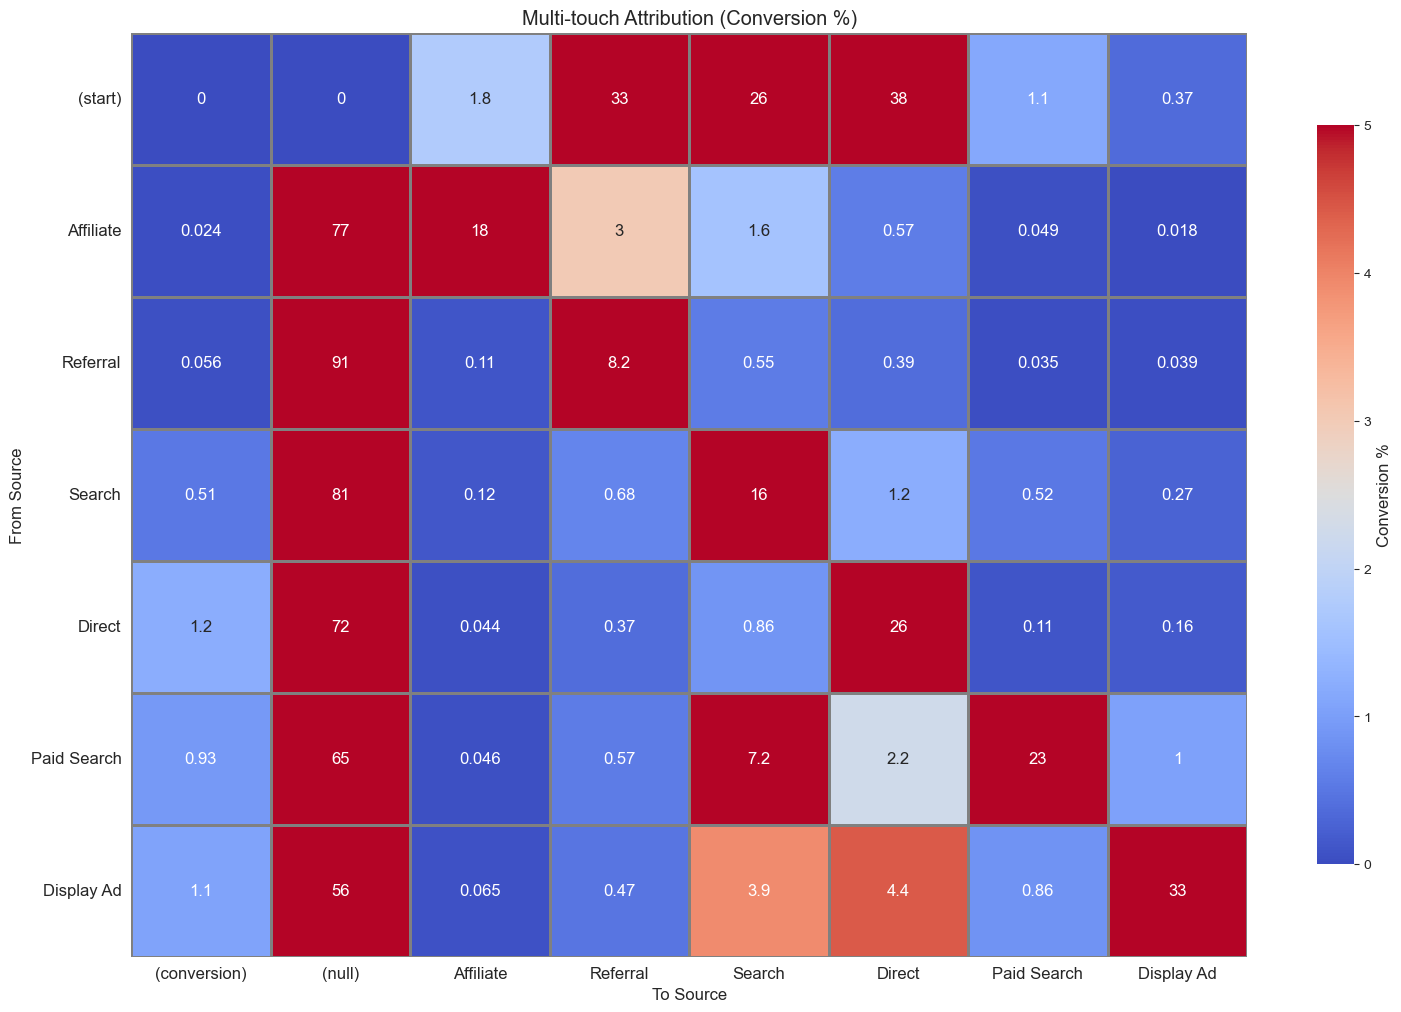

In [69]:
import matplotlib.style as style

#Heat map for transition probabilities in percentage in the data set
fig = plt.figure(figsize=(18, 12))
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(matrix * 100, 
            cmap=sns.color_palette("coolwarm", as_cmap=True),  # Use a diverging colormap
            vmin=0, vmax=5,  # Normalize colormap to range from 0 to 1
            annot=True, center= 2.5, annot_kws={'size': 12}, cbar=True,  # Ensure center at 0.5 for visual balance
            linewidths=1, linecolor='gray',  # Add gridlines between cells
            cbar_kws={"shrink": 0.8, "label": "Conversion %"}  # Shrink the color bar a bit for better visibility
)
plt.title('Multi-touch Attribution (Conversion %)')
plt.xlabel("To Source")
plt.ylabel("From Source")
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12)

# Save the figure
plt.savefig("transition_matrix.svg", dpi=300, bbox_inches='tight')

# Conclusion


The transition matrix from Markov Chain Analysis shows that Direct, Paid Search, and Display Ads demonstrate the highest conversion rates, with visitors often returning via the same channel. However, a significant portion of visits still end without a future interaction (null). The majority of traffic originates from Referral, Direct, and Search, accounting for 97% of all visits.

Analysis of visitor flow reveals that most sources transfer their traffic to Direct as the third most frequent transition, apart from Paid Search, which leads into Search. This suggests that Direct visits and conversions are heavily influenced by previous interactions with other sources. Notably, Display Ads and Paid Search contribute to Direct traffic at rates of 4.4% and 2.2%, respectively.

Multi-touch attribution analysis highlights that Direct generates the most conversions and total conversion value. Display Ads have the highest value per conversion across all attribution models, with a total conversion rate of 152.02, surpassing Paid Search. Additionally, Display Ads exhibit a strong retention rate (33%), much higher than Paid Search (1%), reinforcing their effectiveness in maintaining user engagement.

Further analysis of conversion behavior reveals that 98.48% of conversions come from first-time visitors, while only 1.52% are from returning users. This indicates a need for stronger retention strategies, such as loyalty programs, personalized remarketing, or follow-up email campaigns to encourage repeat visits and conversions.

The analysis is based on data from August 2016 to August 2017, and future assessments should examine whether these trends have persisted or evolved over time. External factors such as seasonality, shifts in advertising effectiveness, and competitive landscape changes may impact the results.

Given these insights, increasing investment in Display Ads is recommended, as they yield high retention and strong conversion value. While Paid Search is valuable in directing traffic to Search and Direct, assessing the return on ad spend and optimizing click-through rates would ensure a more effective budget allocation. Strengthening brand presence via retargeting campaigns and optimizing referral partnerships could also help mitigate high drop-off rates and improve overall conversion performance. Additionally, focusing on retention strategies to improve the returning conversion rate could further enhance long-term profitability.
